当前工作目录: /home/cwy/eeg/EEG/brainmagick
INFO:bm.play:Loading solver from XP 6f74e342. Overrides used: ['dset.selections=[brennan2019]', 'optim.epochs=40', 'optim.batch_size=32']
Opening raw data file /home/cwy/eeg/EEG/brainmagick/cache/studies/brennan2019/S43/meg-sr120-hp0-raw.fif...
Opening raw data file /home/cwy/eeg/EEG/brainmagick/cache/studies/brennan2019/S03/meg-sr120-hp0-raw.fif...
Opening raw data file /home/cwy/eeg/EEG/brainmagick/cache/studies/brennan2019/S23/meg-sr120-hp0-raw.fif...
Opening raw data file /home/cwy/eeg/EEG/brainmagick/cache/studies/brennan2019/S25/meg-sr120-hp0-raw.fif...
Opening raw data file /home/cwy/eeg/EEG/brainmagick/cache/studies/brennan2019/S20/meg-sr120-hp0-raw.fif...
    Range : 0 ... 87485 =      0.000 ...   729.042 secs
Ready.
    Range : 0 ... 87599 =      0.000 ...   729.992 secs
    Range : 0 ... 87767 =      0.000 ...   731.392 secs
Ready.
    Range : 0 ... 88151 =      0.000 ...   734.592 secs
Ready.
Ready.
    Range : 0 ... 88421 =      0.000 

/home/cwy/anaconda3/envs/bm/lib/python3.8/site-packages/flashy/solver.py:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(self.checkpoint_path, 'cpu')


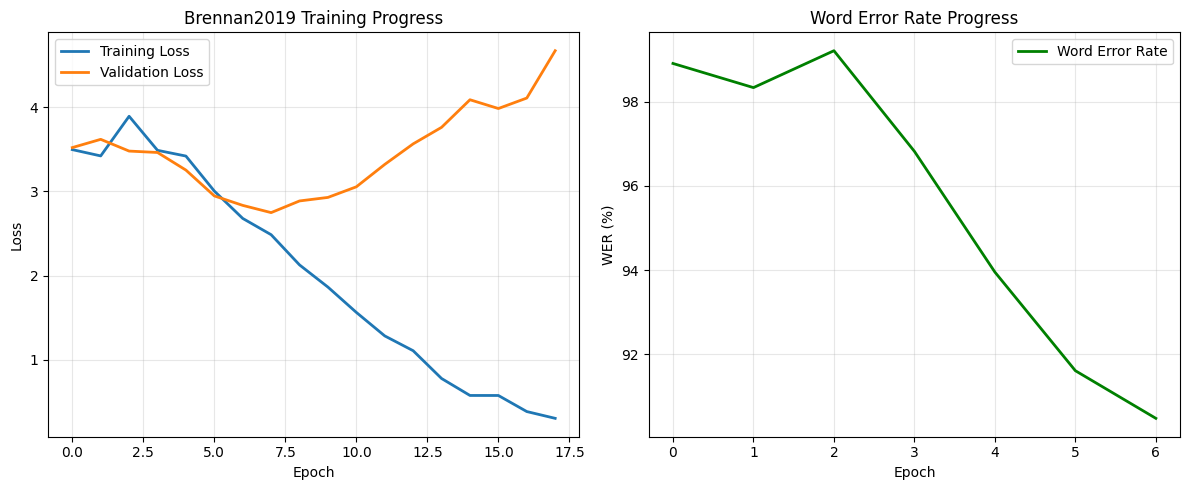


训练结果总结:
总训练轮数: 18
最终训练损失: 0.3053
最佳训练损失: 0.3053
最终验证损失: 4.6695
最佳验证损失: 2.7475
最终WER: 90.47%
最佳WER: 90.47%


In [8]:
import logging
from pathlib import Path
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

# 设置正确的工作目录
import bm
os.chdir(Path(bm.__file__).parent.parent)
print(f"当前工作目录: {os.getcwd()}")

# 导入模块
from bm import play
from bm.train import main

# 关键修复：手动设置正确的dora目录
main.dora.dir = Path("./outputs")  # 修正dora目录
# print(f"修正后的Dora输出目录: {main.dora.dir}")
# print(f"实验目录是否存在: {(main.dora.dir / 'xps' / '6f74e342').exists()}")

# 验证实验文件
exp_dir = main.dora.dir / 'xps' / '6f74e342'
if exp_dir.exists():
   # print(f"✅ 找到实验目录")
    files = list(exp_dir.iterdir())
   # print(f"实验文件: {[f.name for f in files[:5]]}...")  # 显示前5个文件
else:
    print("❌ 实验目录仍然不存在")
    # 让我们查看实际的outputs目录
    actual_outputs = Path("./outputs")
    if actual_outputs.exists():
        xps = actual_outputs / "xps"
        if xps.exists():
            available = [d.name for d in xps.iterdir() if d.is_dir()]
            print(f"可用的实验: {available}")

# 设置日志
# logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# 现在尝试加载实验
sig = '6f74e342'
try:
    solver = play.get_solver_from_sig(sig)
    # print("✅ 实验加载成功！")
    
    # 分析训练历史
    history = solver.history
   # print(f"找到 {len(history)} 个训练epoch")
    
    if len(history) > 0:
        train_losses = [epoch['train']['loss'] for epoch in history if 'train' in epoch]
        valid_losses = [epoch['valid']['loss'] for epoch in history if 'valid' in epoch]
        
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss', linewidth=2)
        plt.plot(valid_losses, label='Validation Loss', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Brennan2019 Training Progress')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 添加WER如果存在
        plt.subplot(1, 2, 2)
        test_wers = []
        for epoch in history:
            if 'test' in epoch and 'wer' in epoch['test']:
                test_wers.append(epoch['test']['wer'] * 100)
        
        if test_wers:
            plt.plot(test_wers, label='Word Error Rate', linewidth=2, color='green')
            plt.xlabel('Epoch')
            plt.ylabel('WER (%)')
            plt.title('Word Error Rate Progress')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 打印结果总结
        print(f"\n{'='*50}")
        print("训练结果总结:")
        print(f"{'='*50}")
        print(f"总训练轮数: {len(history)}")
        if train_losses:
            print(f"最终训练损失: {train_losses[-1]:.4f}")
            print(f"最佳训练损失: {min(train_losses):.4f}")
        if valid_losses:
            print(f"最终验证损失: {valid_losses[-1]:.4f}")
            print(f"最佳验证损失: {min(valid_losses):.4f}")
        if test_wers:
            print(f"最终WER: {test_wers[-1]:.2f}%")
            print(f"最佳WER: {min(test_wers):.2f}%")
        
except Exception as e:
    print(f"❌ 加载实验时出错: {e}")
    import traceback
    traceback.print_exc()